In [ ]:
# install extra dependencies as needed - do not worry about package related pip errors, this does not seem to cause any notable issues (https://github.com/apple/turicreate/issues/3383)
!pip install -q -U ngrok
#!pip install tensorflowjs
!pip install tensorrt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for tensorrt: filename=tensorrt-8.6.1.post1-py2.py3-none-any.whl size=17281 sha256=50aea57d25f74f6c1b1e82748ee2dedd70c7ce7f3610286c9d510da1d7e4ca7f
  Stored in directory: /root/.cache/pip/wheels/f4/c8/0e/b79b08e45752491b9acfdbd69e8a609e8b2ed7640dda5a3e59
Successfully built tensorrt


In [ ]:
import json
import random
import numpy as np
from numpy import mean
from numpy import std
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
# import tensorflowjs as tfjs
from google.colab import drive
import os

In [ ]:
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/neuralNetwork")

Mounted at /content/drive


In [ ]:
newDataDictionary = {}
f = open('./raw_collected_beacon_data.json')
data = json.load(f)
for i in data:
    newDataDictionary[i] = {'B1': [], 'B2': [], 'B3': [],'B4': [],'B5': [],'B6': [],'B7': [],'B8': [], 'B9': [], 'B10': []}
    for j in data[i]:
        newDataDictionary[i]['B1'].append(0)
        newDataDictionary[i]['B2'].append(0)
        newDataDictionary[i]['B3'].append(0)
        newDataDictionary[i]['B4'].append(0)
        newDataDictionary[i]['B5'].append(0)
        newDataDictionary[i]['B6'].append(0)
        newDataDictionary[i]['B7'].append(0)
        newDataDictionary[i]['B8'].append(0)
        newDataDictionary[i]['B9'].append(0)
        newDataDictionary[i]['B10'].append(0)
        for k in data[i][j]:
            newDataDictionary[i][data[i][j][k]['beaconIdentifier']].pop()
            newDataDictionary[i][data[i][j][k]['beaconIdentifier']].append(data[i][j][k]['rssiMeasurement'])

# close file
f.close()

In [ ]:
averages = {}
for i in newDataDictionary:
    averages[i] = {'B1': [], 'B2': [], 'B3': [],'B4': [],'B5': [],'B6': [],'B7': [],'B8': [], 'B9': [], 'B10': []}
    for j in newDataDictionary[i]:
        for k in range(len(newDataDictionary[i][j])):
            if k >= 9:
                sum = int(newDataDictionary[i][j][k]) + int(newDataDictionary[i][j][k-1]) + int(newDataDictionary[i][j][k-2]) + int(newDataDictionary[i][j][k-3]) + int(newDataDictionary[i][j][k-4])+ int(newDataDictionary[i][j][k-5]) + int(newDataDictionary[i][j][k-6]) + int(newDataDictionary[i][j][k-7])+ int(newDataDictionary[i][j][k-8]) + int(newDataDictionary[i][j][k-9])
                count = 10
                averages[i][j].append(sum/count)

In [ ]:
beaconsForNormalization = {}
for average in averages:
    for beacon in averages[average]:
        beaconsForNormalization[average] = []
        for i in range(len(averages[average][beacon])):
            newList = [abs(averages[average]['B1'][i]), abs(averages[average]['B2'][i]), abs(averages[average]['B3'][i]), abs(averages[average]['B4'][i]), abs(averages[average]['B5'][i]), abs(averages[average]['B6'][i]), abs(averages[average]['B7'][i]), abs(averages[average]['B8'][i]), abs(averages[average]['B9'][i]), abs(averages[average]['B10'][i])]
            normalizedList = normalize([newList], norm="l1")
            beaconsForNormalization[average].append(normalizedList[0].tolist())

In [ ]:
smallestLength = 10000000000000000000000
for node in beaconsForNormalization:
    if (smallestLength > len(beaconsForNormalization[node])):
        smallestLength = len(beaconsForNormalization[node]);

In [ ]:
for node in beaconsForNormalization:
    beaconsForNormalization[node] = beaconsForNormalization[node][0:smallestLength]

In [ ]:
classesToCode = [node for node in beaconsForNormalization]
# integer mapping using LabelEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(classesToCode)

In [ ]:


integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

In [ ]:
# one hot encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

In [ ]:
newArrangement = []
indexNumber = 0
for node in beaconsForNormalization:
    hot_encoded = onehot_encoded[indexNumber]
    indexNumber += 1
    for i in range(len(beaconsForNormalization[node])):
        newArrangement.append([beaconsForNormalization[node][i], hot_encoded.tolist()])

In [ ]:
X = []
y = []
for i in range(len(newArrangement)):
    X.append(newArrangement[i][0])
    y.append(newArrangement[i][1])

X = np.array(X)
y = np.array(y)

In [ ]:
graph = tf.keras.callbacks.TensorBoard(
    log_dir="logs",
    histogram_freq=0,
    write_graph=True,
    write_images=False,
    write_steps_per_second=False,
    update_freq="epoch",
    profile_batch=0,
    embeddings_freq=0,
    embeddings_metadata=None)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=2000,
)

In [ ]:
modelFilepath = "best_model.hdf5"
best_model = tf.keras.callbacks.ModelCheckpoint(
    filepath=modelFilepath,
    monitor='val_accuracy',
    mode='auto',
    save_best_only=True)

In [ ]:
def get_model(n_inputs, n_outputs):
  # define the model
  model = Sequential()
  model.add(Dense(20, input_dim= n_inputs, kernel_initializer='he_uniform', activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(n_outputs, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [ ]:
results = list()
n_inputs, n_outputs = X.shape[1], y.shape[1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [ ]:
# define model
model = get_model(n_inputs, n_outputs)
# @tf.autograph.experimental.do_not_convert
model.fit(X_train, y_train, verbose=2, validation_split = 0.1, epochs=4000, callbacks=[graph, best_model, early_stop])
evaluation = model.evaluate(X_test, y_test, verbose=2)
# store result
print(evaluation)
results.append(evaluation)

Epoch 1/4000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


148/148 - 3s - loss: 3.6937 - accuracy: 0.0730 - val_loss: 3.6005 - val_accuracy: 0.1426 - 3s/epoch - 18ms/step
Epoch 2/4000
148/148 - 0s - loss: 3.4721 - accuracy: 0.1373 - val_loss: 3.3188 - val_accuracy: 0.1464 - 456ms/epoch - 3ms/step
Epoch 3/4000
148/148 - 0s - loss: 3.1776 - accuracy: 0.1586 - val_loss: 3.0061 - val_accuracy: 0.2262 - 335ms/epoch - 2ms/step
Epoch 4/4000
148/148 - 0s - loss: 2.9138 - accuracy: 0.2164 - val_loss: 2.7489 - val_accuracy: 0.3061 - 323ms/epoch - 2ms/step
Epoch 5/4000
148/148 - 0s - loss: 2.7040 - accuracy: 0.2439 - val_loss: 2.5546 - val_accuracy: 0.3935 - 358ms/epoch - 2ms/step
Epoch 6/4000
148/148 - 0s - loss: 2.5415 - accuracy: 0.2671 - val_loss: 2.3984 - val_accuracy: 0.4620 - 372ms/epoch - 3ms/step
Epoch 7/4000
148/148 - 0s - loss: 2.4015 - accuracy: 0.3018 - val_loss: 2.2646 - val_accuracy: 0.4772 - 350ms/epoch - 2ms/step
Epoch 8/4000
148/148 - 0s - loss: 2.3087 - accuracy: 0.3105 - val_loss: 2.1534 - val_accuracy: 0.4905 - 347ms/epoch - 2ms/step

In [ ]:
# only run if your computer will support tensorboard - this needs to run on localhost after ngrok registration (https://ngrok.com/)
# %load_ext tensorboard
# %tensorboard --logdir logs

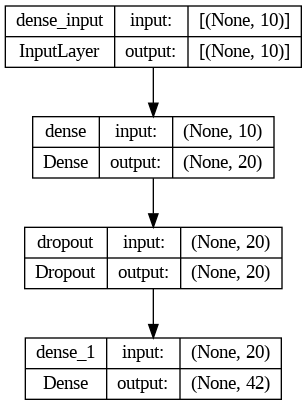

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
# tfjs.converters.save_keras_model(model, './final_model/B/tmp')